In [1]:
%matplotlib inline

# ALE meta-analysis

In [2]:
import os
from os import listdir
from os.path import isfile, join
import nibabel as nib
from pathlib import Path

import matplotlib.pyplot as plt
from nilearn.plotting import plot_stat_map
from nimare.io import convert_sleuth_to_dataset
from nimare.utils import get_resource_path

from nimare.correct import FWECorrector
from nimare.meta.cbma import ALE

##Conjunctions
import copy
from nilearn.image import math_img
import numpy as np

ERROR:duecredit:Failed to import duecredit due to No module named 'duecredit'


In [3]:
_dset_folder = r'../data_db/dataset_ale/'
_nii_folder = r'../data_db/nifti-ale/by_exp/'
_nii_folder_z = r'../data_db/nifti-ale/by_exp/z_nii/'
_res_folder = r'../data_db/res/by_exp/'
_nii_combos_folder = r'../data_db/nifti-ale/combos/by_exp/'
_threshold = 1.644854 # cluster-level p < .05, one-tailed

## ALE Working Memory: visual task stimulus and task modality n-task

In [4]:
dsetfiles = {Path(f).stem: f for f in listdir(_dset_folder) if isfile(join(_dset_folder, f))}

In [5]:
files = {k: os.path.join(os.path.abspath(_dset_folder), file_name) for k, file_name in dsetfiles.items()}
dsets = {k: convert_sleuth_to_dataset(f) for k, f in files.items()}

In [6]:
corrected_results = {}
# ale = ALE(null_method="montecarlo",n_iters=100,n_cores=8)
ale = ALE(null_method="approximate")
corr = FWECorrector(method="montecarlo", voxel_thresh=0.001, n_iters=100, n_cores=8)
for index, (k, dset) in enumerate(dsets.items()):
    result = ale.fit(dset)
    corrected_results[k] = corr.transform(result)

INFO:nimare.correct:Using correction method implemented in Estimator: nimare.meta.cbma.ale.ALE.correct_fwe_montecarlo.
100%|██████████| 100/100 [00:10<00:00,  9.55it/s]
INFO:nimare.meta.cbma.base:Using null distribution for voxel-level FWE correction.
INFO:nimare.correct:Using correction method implemented in Estimator: nimare.meta.cbma.ale.ALE.correct_fwe_montecarlo.
100%|██████████| 100/100 [00:05<00:00, 17.65it/s]
INFO:nimare.meta.cbma.base:Using null distribution for voxel-level FWE correction.
INFO:nimare.correct:Using correction method implemented in Estimator: nimare.meta.cbma.ale.ALE.correct_fwe_montecarlo.
100%|██████████| 100/100 [00:07<00:00, 14.17it/s]
INFO:nimare.meta.cbma.base:Using null distribution for voxel-level FWE correction.
INFO:nimare.correct:Using correction method implemented in Estimator: nimare.meta.cbma.ale.ALE.correct_fwe_montecarlo.
100%|██████████| 100/100 [00:08<00:00, 12.45it/s]
INFO:nimare.meta.cbma.base:Using null distribution for voxel-level FWE corr

In [7]:
corrected_results

{'select00_test': <nimare.results.MetaResult at 0x1ffd05e9160>,
 'select01_wm': <nimare.results.MetaResult at 0x1ffd050e970>,
 'select02_wm_decision-making': <nimare.results.MetaResult at 0x1ffd05e9310>,
 'select03_reward_anticipation_rw-norw': <nimare.results.MetaResult at 0x1ffeac9dac0>,
 'select04_reward_anticipation_high_low_rew': <nimare.results.MetaResult at 0x1ffd050e9d0>,
 'select05_reward_anticipation_exp_recv_rew': <nimare.results.MetaResult at 0x1ffd06a85b0>,
 'select06_reward_outcome_rw-norw': <nimare.results.MetaResult at 0x1ffd08c7880>,
 'select07_reward_outcome_risk-safe': <nimare.results.MetaResult at 0x1ffd08c7520>,
 'select08_reward_outcome_high-low': <nimare.results.MetaResult at 0x1ffd06b19a0>,
 'select09_reward_outcome_win-lose': <nimare.results.MetaResult at 0x1ffd08c73d0>,
 'select10_reward_decision-making_outcome': <nimare.results.MetaResult at 0x1ffd08d2a00>,
 'select11_reward_decision-making_anticipation': <nimare.results.MetaResult at 0x1ffd06b1df0>,
 'select

C:\ProgramData\Anaconda3\envs\tfg-env\lib\site-packages\nilearn\plotting\img_plotting.py:300: FutureWarning: Default resolution of the MNI template will change from 2mm to 1mm in version 0.10.0
  anat_img = load_mni152_template()
C:\ProgramData\Anaconda3\envs\tfg-env\lib\site-packages\nilearn\plotting\displays\_slicers.py:383: UserWarning: empty mask
  get_mask_bounds(new_img_like(img, not_mask, affine))


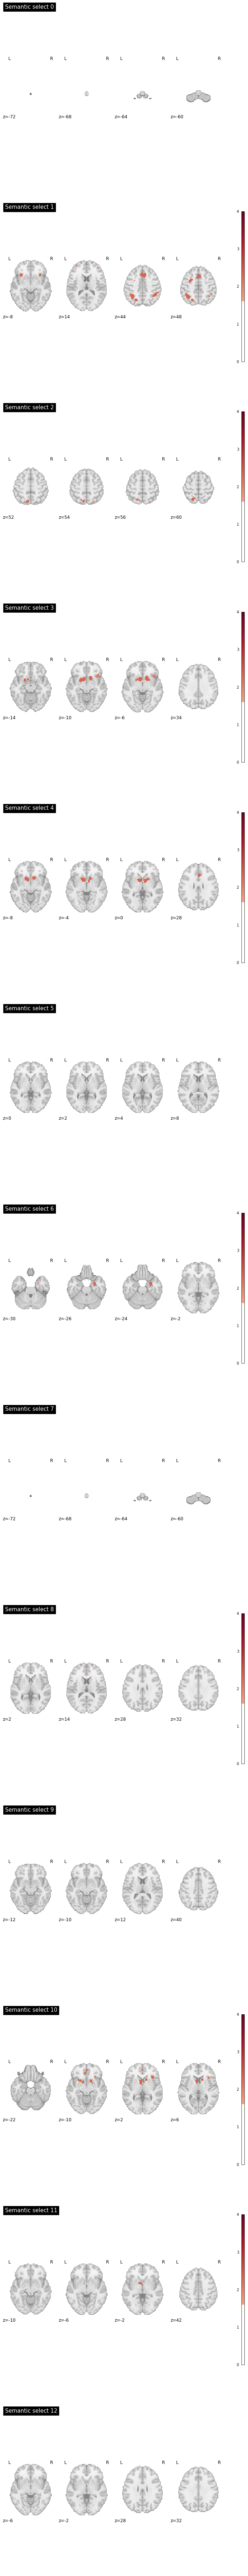

In [8]:
#!!!!!!! "stat" is the ALE map but we use z after the correction is made to be relevant otherwise we should've made ALE in a different way
## Check
map_name = "z_desc-size_level-cluster_corr-FWE_method-montecarlo"
imgs = {}
res_len = len(corrected_results)
fig, axes = plt.subplots(figsize=(12, res_len * 10), nrows=res_len)
for index, (k, corr_result) in enumerate(corrected_results.items()):
    imgs[k] = corr_result.get_map(
        map_name
    )

    plot_stat_map(
        imgs[k],
        cut_coords=4,
        display_mode="z",
        title="Semantic select " + str(index),
        threshold=_threshold,
        cmap="RdBu_r",
        vmax=4,
        axes=axes[index],
        figure=fig,
    )


## Save images to nifti

In [9]:
# for index, (file_name, img) in enumerate(imgs.items()):
#     nib.save(img, os.path.join(os.path.abspath(_nii_folder), file_name + '.nii'))
#     nib.save(corrected_results[file_name].get_map('z'),
#              os.path.join(os.path.abspath(_nii_folder_z), file_name + '-z.nii'))

## Statistics

In [10]:
from IPython.display import display
from nimare.diagnostics import FocusCounter

counter = FocusCounter(
    target_image="z_desc-size_level-cluster_corr-FWE_method-montecarlo",
    voxel_thresh=_threshold,
)
for index, (file_name, corr_res) in enumerate(corrected_results.items()):
    print(file_name)
    count_table, _ = counter.transform(corr_res)
    print(count_table.shape)
    display(count_table)

select00_test


C:\ProgramData\Anaconda3\envs\tfg-env\lib\site-packages\nilearn\_utils\param_validation.py:72: UserWarning: The given float value must not exceed 0.0. But, you have given threshold=1.644854 
  warnings.warn("The given float value must not exceed {0}. "


(2, 0)


""
Center of Mass
Test test test-


select01_wm


100%|██████████| 12/12 [00:00<00:00, 35.90it/s]

(13, 11)


,1,2,3,4,5,6,7,8,9,10,11
Cluster ID,,,,,,,,,,,
Center of Mass,"(44, -47, 44)","(39, 43, 20)","(31, 5, 54)","(32, 22, -1)","(1, 19, 46)","(-22, -66, 44)","(-27, 2, 53)","(-31, 22, -1)","(-37, -52, 46)","(-36, 51, 5)","(-44, 6, 28)"
Beneventi et al-An fMRI study of working memor..,0,0,1,1,1,0,0,1,1,0,1
Carrion et al-Frontal Hypoactivation on Func..,2,1,0,2,1,2,2,2,3,2,0
Di et al-Anterior cingulate cortex diff..,0,0,1,0,0,1,1,1,0,2,1
Drobyshevsky et al-A Rapid fMRI Task Battery for ..,1,0,1,0,1,1,1,0,1,0,0
Duggirala et al-Stimulus-dependent modulation ..,0,2,0,6,4,0,1,4,9,0,4
Lee et al-Abnormal neural activity in pa..,1,0,0,1,3,1,2,1,2,2,1
Padilla et al-Long-term brain effects of N-b..,3,0,1,0,3,0,2,1,1,1,1
Pochon et al-The neural system that bridges..,0,0,0,0,0,0,0,0,0,0,0


select02_wm_decision-making


100%|██████████| 3/3 [00:00<00:00, 90.83it/s]

(4, 2)


,1,2
Cluster ID,,
Center of Mass,"(28, -68, 47)","(-15, -65, 56)"
Cruz et al-Alterations in the functional ..,1,1
Nobre et al-Orienting Attention to Locatio..,3,3
Reilhac et al-Role of the superior parietal ..,2,2


select03_reward_anticipation_rw-norw


100%|██████████| 8/8 [00:00<00:00, 77.60it/s]

(9, 3)


,1,2,3
Cluster ID,,,
Center of Mass,"(40, 20, -8)","(11, 3, 0)","(-11, 7, -7)"
Cohen et al-Individual differences in extr..,0,1,0
John O Doherty et al-Neural Responses during Antici..,0,0,0
Kirscg et al-Anticipation of reward in a no..,2,5,3
Knutson et al-A region of mesial prefrontal ..,1,3,2
Knutson et al-Anticipation of Increasing Mon..,0,3,1
Knutson et al-Dissociation of reward anticip..,1,3,3
Koeneke et al-Individual preferences modulat..,1,0,0
Spreckelmeyer et al-Anticipation of monetary and s..,0,5,4


select04_reward_anticipation_high_low_rew


100%|██████████| 8/8 [00:00<00:00, 80.73it/s]

(9, 3)


,1,2,3
Cluster ID,,,
Center of Mass,"(12, 10, -3)","(2, 24, 28)","(-11, 8, -2)"
Abler et al-From uncertainty to reward - B..,1,1,3
Croxson et al-Effort-Based Cost Benefit Valu..,1,0,1
Jarcho et al-Developmental effects of decis..,0,0,1
Knutson et al-Anticipation of Increasing Mon..,2,2,2
Knutson et al-Distributed Neural Representat..,3,1,3
Smith et al-Neural substrates of reward ma..,0,0,0
Spreckelmeyer et al-Anticipation of monetary and s..,6,2,7
Tobler et al-Reward Value Coding Distinct F..,1,0,2


select05_reward_anticipation_exp_recv_rew


C:\ProgramData\Anaconda3\envs\tfg-env\lib\site-packages\nilearn\_utils\param_validation.py:72: UserWarning: The given float value must not exceed 0.8064212470182404. But, you have given threshold=1.644854 
  warnings.warn("The given float value must not exceed {0}. "


(4, 0)


""
Center of Mass
John O Doherty et al-Neural Responses during Antici..
Rademacher et al-Dissociation of neural network..
Tobler et al-Reward Value Coding Distinct F..


select06_reward_outcome_rw-norw


100%|██████████| 10/10 [00:00<00:00, 111.01it/s]

(11, 1)


,1
Cluster ID,
Center of Mass,"(28, -3, -23)"
Cohen et al-Individual differences in extr..,1
Elliott et al-Differential Response Patterns..,1
Elliott et al-Instrumental responding for re..,2
John O Doherty et al-Neural Responses during Antici..,0
Knutson et al-A region of mesial prefrontal ..,0
Knutson et al-Dissociation of reward anticip..,0
Koeneke et al-Individual preferences modulat..,0
Schienle et al-Binge-Eating Disorder Reward ..,1


select07_reward_outcome_risk-safe


C:\ProgramData\Anaconda3\envs\tfg-env\lib\site-packages\nilearn\_utils\param_validation.py:72: UserWarning: The given float value must not exceed 0.0. But, you have given threshold=1.644854 
  warnings.warn("The given float value must not exceed {0}. "


(4, 0)


""
Center of Mass
Abler et al-From uncertainty to reward - B..
Lawrence et al-Distinct Roles of Prefrontal C..
Xue et al-Functional Dissociations of Ri..


select08_reward_outcome_high-low


100%|██████████| 9/9 [00:00<00:00, 112.40it/s]

(10, 1)


,1
Cluster ID,
Center of Mass,"(1, 36, 9)"
Abler et al-From uncertainty to reward - B..,0
Cloutier et al-Are Attractive People Rewardin..,2
Delgado et al-Dorsal striatum responses to r..,0
Elliott et al-Dissociable Neural Responses i..,0
Jarcho et al-Developmental effects of decis..,0
Knutson et al-Dissociation of reward anticip..,0
Nieuwenhuis et al-Activity in human reward-sensi..,0
Signe Bray and John O'Doherty-Neural Coding of Reward-Predic..,1


select09_reward_outcome_win-lose


C:\ProgramData\Anaconda3\envs\tfg-env\lib\site-packages\nilearn\_utils\param_validation.py:72: UserWarning: The given float value must not exceed 1.475791028179171. But, you have given threshold=1.644854 
  warnings.warn("The given float value must not exceed {0}. "


(7, 0)


""
Center of Mass
Christakou et al-Right Ventromedial and Dorsola..
Fujiwara et al-Segregated and Integrated Codi..
Greck et al-Is our self based on reward - ..
Lawrence et al-Distinct Roles of Prefrontal C..
Vassena et al-Dissociating contributions of ..
Xue et al-Functional Dissociations of Ri..


select10_reward_decision-making_outcome


100%|██████████| 22/22 [00:00<00:00, 63.65it/s]

(23, 4)


,1,2,3,4
Cluster ID,,,,
Center of Mass,"(32, 25, -2)","(15, 11, -3)","(-1, 49, -7)","(-14, 9, -5)"
Abler et al-From uncertainty to reward - B..,1,1,1,3
Akitsuki et al-Context-dependent cortical act..,0,0,2,1
Christakou et al-Right Ventromedial and Dorsola..,0,0,0,1
Cohen et al-Individual differences in extr..,0,1,0,1
Cox et al-Learning to Like A Role for H..,0,0,0,1
Delgado et al-Tracking the Hemodynamic Respo..,0,2,0,4
Elliott et al-Dissociable Neural Responses i..,0,0,1,1
Elliott et al-Instrumental responding for re..,0,0,1,0


select11_reward_decision-making_anticipation


100%|██████████| 7/7 [00:00<00:00, 89.66it/s]

(8, 2)


,1,2
Cluster ID,,
Center of Mass,"(-9, 6, 1)","(-19, -14, -15)"
Abler et al-From uncertainty to reward - B..,3,1
Cohen et al-Individual differences in extr..,0,0
Jarcho et al-Developmental effects of decis..,1,0
Koeneke et al-Individual preferences modulat..,0,0
Rosell-Negre et al-Monetary reward magnitude effe..,1,0
Smith et al-Neural substrates of reward ma..,0,2
Tobler et al-Reward Value Coding Distinct F..,3,1


select12_reward_decision-making_decision


C:\ProgramData\Anaconda3\envs\tfg-env\lib\site-packages\nilearn\_utils\param_validation.py:72: UserWarning: The given float value must not exceed 1.3407550336902165. But, you have given threshold=1.644854 
  warnings.warn("The given float value must not exceed {0}. "


(5, 0)


""
Center of Mass
Lawrence et al-Distinct Roles of Prefrontal C..
Rogers et al-Distinct Portions of Anterior ..
Schonberg et al-Decreasing ventromedial prefro..
Vassena et al-Dissociating contributions of ..


## Conjunctions

In [11]:
tmp_imgs = copy.deepcopy(imgs)

In [12]:
dict_keys = list(tmp_imgs.keys())
dict_keys

['select00_test',
 'select01_wm',
 'select02_wm_decision-making',
 'select03_reward_anticipation_rw-norw',
 'select04_reward_anticipation_high_low_rew',
 'select05_reward_anticipation_exp_recv_rew',
 'select06_reward_outcome_rw-norw',
 'select07_reward_outcome_risk-safe',
 'select08_reward_outcome_high-low',
 'select09_reward_outcome_win-lose',
 'select10_reward_decision-making_outcome',
 'select11_reward_decision-making_anticipation',
 'select12_reward_decision-making_decision']

In [13]:
%%time
formula = "np.where(img1 * img2 > 0, np.minimum(img1, img2), 0)"
img_conj = math_img(formula, img1=copy.deepcopy(tmp_imgs[dict_keys[3]]), img2=copy.deepcopy(tmp_imgs[dict_keys[11]]))
num_vox = np.sum(img_conj.get_fdata() > 0)
num_vox

CPU times: total: 344 ms
Wall time: 343 ms


59

TEST the conjunctions 3 vs 2x2
//1,4,12
//3 4 11

In [14]:
%%time
formula = "np.where(img1 * img2 * img3 > 0, np.minimum(img1, img2,img3), 0)"
img_conj1 = math_img(formula,
                     img1=copy.deepcopy(tmp_imgs[dict_keys[3]]),
                     img2=copy.deepcopy(tmp_imgs[dict_keys[4]]),
                     img3=copy.deepcopy(tmp_imgs[dict_keys[9]]))
num_vox = np.sum(img_conj1.get_fdata() > 0)
num_vox

CPU times: total: 469 ms
Wall time: 470 ms


49

In [15]:
%%time
formula = "np.where(img1 * img2 > 0, np.minimum(img1, img2), 0)"
img_conj2 = math_img(formula,
                     img1=copy.deepcopy(img_conj1),
                     img2=copy.deepcopy(tmp_imgs[dict_keys[10]]))
num_vox = np.sum(img_conj2.get_fdata() > 0)
num_vox

CPU times: total: 328 ms
Wall time: 324 ms


46

In [16]:
%%time
formula = "np.where(img1 * img2 > 0, np.minimum(img1, img2), 0)"
img_conj3 = math_img(formula,
                     img1=copy.deepcopy(img_conj2),
                     img2=copy.deepcopy(tmp_imgs[dict_keys[8]]))
num_vox = np.sum(img_conj3.get_fdata() > 0)
num_vox

CPU times: total: 312 ms
Wall time: 312 ms


0

### Get non null pixels

In [17]:
t1_data = img_conj.get_fdata()
t1_data.shape

(91, 109, 91)

In [18]:
pts_lst = []
for i in range(t1_data.shape[0]):
    for j in range(t1_data.shape[1]):
        for k in range(t1_data.shape[2]):
            if t1_data[i, j, k] != 0: pts_lst.append([i, j, k])

In [19]:
len(pts_lst)

59

## Save img to nifti

In [20]:
# img_to_save = img_conj1
# img_name = 'img_combo1_4'
# nib.save(img_to_save, os.path.join(os.path.abspath(_nii_combos_folder), img_name + '.nii'))

## recursive conjunctions

In [21]:
# Create a base nifti
base_img = math_img("np.where(img1  > 0, 10000,10000)", img1=copy.deepcopy(tmp_imgs[dict_keys[0]]))

In [22]:
### !! Check for empty maps
rec_list = ['base_img',
            'select01_wm',
            'select02_wm_decision-making',
            'select03_reward_anticipation_rw-norw',
            'select04_reward_anticipation_high_low_rew',
            'select05_reward_anticipation_exp_recv_rew',
            'select06_reward_outcome_rw-norw',
            'select07_reward_outcome_risk-safe', # Empty
            'select08_reward_outcome_high-low',
            'select09_reward_outcome_win-lose',
            'select10_reward_decision-making_outcome',
            'select11_reward_decision-making_anticipation',
            'select12_reward_decision-making_decision']

In [23]:
path_set = set()
tmp_imgs['base_img'] = base_img

In [24]:
formula = "np.where(img1 * img2 > 0, np.minimum(img1, img2), 0)"

def recursive_conjunction(index, img_conj, path):
    if index == len(rec_list): return
    img_conj = math_img(formula, img1=copy.deepcopy(img_conj), img2=copy.deepcopy(tmp_imgs[rec_list[index]]))
    if np.sum(img_conj.get_fdata() > 0):
        path_set.add(tuple(path))
    else:
        return
    print(tuple(path))
    for i in range(index + 1, len(rec_list) + 1):
        recursive_conjunction(i, copy.deepcopy(img_conj), path + [i])
    return


In [25]:
recursive_conjunction(0, base_img, [])

()
(1,)
(1, 2)
(1, 3)
(1, 4)
(1, 4, 10)
(1, 4, 10, 12)
(1, 4, 12)
(1, 5)
(1, 10)
(1, 10, 12)
(1, 11)
(1, 12)
(2,)
(3,)
(3, 4)
(3, 4, 9)
(3, 4, 9, 10)
(3, 4, 10)
(3, 4, 10, 11)
(3, 4, 11)
(3, 4, 12)
(3, 9)
(3, 9, 10)
(3, 10)
(3, 10, 11)
(3, 11)
(3, 12)
(4,)
(4, 9)
(4, 9, 10)
(4, 10)
(4, 10, 11)
(4, 10, 12)
(4, 11)
(4, 12)
(5,)
(6,)
(6, 10)
(8,)
(8, 9)
(9,)
(9, 10)
(10,)
(10, 11)
(10, 12)
(11,)
(12,)


In [26]:
print(path_set)

{(3, 9, 10), (2,), (3, 4), (5,), (4, 9), (4, 9, 10), (11,), (4, 10, 11), (4, 12), (3, 10), (8,), (8, 9), (3, 10, 11), (1, 10, 12), (3, 4, 9, 10), (1, 3), (10, 12), (1, 12), (3, 4, 10), (3, 4, 10, 11), (4,), (1,), (3, 9), (10,), (3, 12), (4, 11), (9, 10), (1, 2), (10, 11), (1, 5), (1, 11), (3, 4, 9), (1, 4, 10), (1, 4, 10, 12), (3, 4, 12), (6, 10), (3,), (9,), (3, 11), (6,), (4, 10), (12,), (4, 10, 12), (1, 4), (3, 4, 11), (1, 4, 12), (1, 10), ()}


## Save models to pickle

In [27]:
import pickle
import csv

In [28]:
path_set_file_name = r'path_set.dump'
pickle.dump(path_set, open(os.path.join(os.path.abspath(_res_folder), path_set_file_name), 'wb'))


## Load models from pickle

In [29]:
retrieved_path_set = pickle.load(open(os.path.join(os.path.abspath(_res_folder), path_set_file_name), 'rb'))
retrieved_path_set

{(),
 (1,),
 (1, 2),
 (1, 3),
 (1, 4),
 (1, 4, 10),
 (1, 4, 10, 12),
 (1, 4, 12),
 (1, 5),
 (1, 10),
 (1, 10, 12),
 (1, 11),
 (1, 12),
 (2,),
 (3,),
 (3, 4),
 (3, 4, 9),
 (3, 4, 9, 10),
 (3, 4, 10),
 (3, 4, 10, 11),
 (3, 4, 11),
 (3, 4, 12),
 (3, 9),
 (3, 9, 10),
 (3, 10),
 (3, 10, 11),
 (3, 11),
 (3, 12),
 (4,),
 (4, 9),
 (4, 9, 10),
 (4, 10),
 (4, 10, 11),
 (4, 10, 12),
 (4, 11),
 (4, 12),
 (5,),
 (6,),
 (6, 10),
 (8,),
 (8, 9),
 (9,),
 (9, 10),
 (10,),
 (10, 11),
 (10, 12),
 (11,),
 (12,)}

In [30]:
lst_models = list(retrieved_path_set)
lst_models.sort(key=lambda x: len(x) if type(x) is tuple else 1)
display(lst_models)

[(),
 (2,),
 (5,),
 (11,),
 (8,),
 (4,),
 (1,),
 (10,),
 (3,),
 (9,),
 (6,),
 (12,),
 (3, 4),
 (4, 9),
 (4, 12),
 (3, 10),
 (8, 9),
 (10, 12),
 (1, 3),
 (1, 12),
 (3, 9),
 (3, 12),
 (4, 11),
 (9, 10),
 (1, 2),
 (10, 11),
 (1, 5),
 (1, 11),
 (6, 10),
 (3, 11),
 (4, 10),
 (1, 4),
 (1, 10),
 (3, 9, 10),
 (4, 9, 10),
 (4, 10, 11),
 (3, 10, 11),
 (1, 10, 12),
 (3, 4, 10),
 (3, 4, 9),
 (1, 4, 10),
 (3, 4, 12),
 (4, 10, 12),
 (3, 4, 11),
 (1, 4, 12),
 (3, 4, 9, 10),
 (3, 4, 10, 11),
 (1, 4, 10, 12)]

In [31]:
lst_file_name = r'path_list.dump'
pickle.dump(path_set, open(os.path.join(os.path.abspath(_res_folder), lst_file_name), 'wb'))
# writing the data into the file
lst_file_name_csv = r'path_list.csv'
with open(os.path.join(os.path.abspath(_res_folder), lst_file_name_csv), 'w', newline='') as f:
    write = csv.writer(f)
    write.writerows(lst_models)

## Convert to BA

In [32]:
lst_models = [list(x) for x in lst_models]

### Eliminate the singular models

In [33]:
lst_models = [x for x in lst_models if len(x)]# and len(x) >1]
lst_models

[[2],
 [5],
 [11],
 [8],
 [4],
 [1],
 [10],
 [3],
 [9],
 [6],
 [12],
 [3, 4],
 [4, 9],
 [4, 12],
 [3, 10],
 [8, 9],
 [10, 12],
 [1, 3],
 [1, 12],
 [3, 9],
 [3, 12],
 [4, 11],
 [9, 10],
 [1, 2],
 [10, 11],
 [1, 5],
 [1, 11],
 [6, 10],
 [3, 11],
 [4, 10],
 [1, 4],
 [1, 10],
 [3, 9, 10],
 [4, 9, 10],
 [4, 10, 11],
 [3, 10, 11],
 [1, 10, 12],
 [3, 4, 10],
 [3, 4, 9],
 [1, 4, 10],
 [3, 4, 12],
 [4, 10, 12],
 [3, 4, 11],
 [1, 4, 12],
 [3, 4, 9, 10],
 [3, 4, 10, 11],
 [1, 4, 10, 12]]

### Create the Conjugate images

In [34]:
import tqdm

In [35]:
formula = "np.where(img1 * img2 > 0, np.minimum(img1, img2), 0)"
img_conjugates = []
for model in tqdm.tqdm(lst_models):
    if not model: continue
    img_conj = copy.deepcopy(base_img)
    for i in range(len(model)):
        img_conj = math_img(formula,
                            img1=copy.deepcopy(img_conj),
                            img2=copy.deepcopy(tmp_imgs[dict_keys[model[i]]]))
    # num_vox = np.sum(img_conj.get_fdata() > 0)
    img_conjugates.append(img_conj)

100%|██████████| 47/47 [00:32<00:00,  1.43it/s]


### Obtain non null coordinates

In [36]:
def get_non_null_nifti_val(nifti):
    pts_lst = []
    for i in range(nifti.get_fdata().shape[0]):
        for j in range(nifti.get_fdata().shape[1]):
            for k in range(nifti.get_fdata().shape[2]):
                if nifti.get_fdata()[i, j, k] != 0: pts_lst.append([i, j, k])
    return pts_lst

In [37]:
pts_list_conj = []
for img in tqdm.tqdm(img_conjugates):
    pts_list_conj.append(get_non_null_nifti_val(img))

100%|██████████| 47/47 [00:32<00:00,  1.46it/s]


### Convert the Coordinates

In [38]:
from scipy.interpolate import interp1d
import util.function_conv_mni as util_conv
import importlib

importlib.reload(util_conv)

<module 'util.function_conv_mni' from 'D:\\scul\\uaic-ub\\licenta\\code\\util\\function_conv_mni.py'>

In [39]:
#Interpolation
X = [[1, 91], [1, 109], [1, 91]]
Y = [[-90, 90], [-126, 90], [-72, 108]]
# test value
x_interp = interp1d(X[0], Y[0])
y_interp = interp1d(X[1], Y[1])
z_interp = interp1d(X[2], Y[2])

In [40]:
pts_list_conj_conv = []
for pts in pts_list_conj:
    pts_list_conj_conv.append([[x_interp(x).item(), y_interp(y).item(), z_interp(z).item()] for x, y, z in pts])

In [41]:
one_line_lst = []
table_lst = []
for pts in pts_list_conj_conv:
    one_line, table = util_conv.find_structure(pts)
    one_line_lst.append(one_line)
    table_lst.append(table)

In [42]:
# for i in range(len(one_line_lst[34])):
#     print(one_line_lst[34][i])

### Parse the results


In [43]:
one_line_lst_parsed = []
for ind, results in enumerate(one_line_lst):
    set_lst = [set() for x in range(7)]
    set_lst[0] = (ind, lst_models[ind])
    for result in results:
        for index, el in enumerate(result.split("//")):
            if index == 0 or el.rstrip().lstrip() == 'undefined': continue
            set_lst[index].add(el)
    one_line_lst_parsed.append(set_lst)

In [44]:
one_line_lst_parsed

[[(0, [2]),
  {' Left Cerebrum ', ' Right Cerebrum '},
  {' Parietal Lobe '},
  {' Inferior Parietal Lobule ',
   ' Precuneus ',
   ' Sub-Gyral ',
   ' Superior Parietal Lobule '},
  {' Gray Matter ', ' White Matter '},
  {' brodmann area 19 ', ' brodmann area 39 ', ' brodmann area 7 '},
  {' Angular_L (aal)',
   ' Occipital_Mid_L (aal)',
   ' Parietal_Inf_L (aal)',
   ' Parietal_Sup_L (aal)',
   ' Parietal_Sup_R (aal)',
   ' Precuneus_R (aal)'}],
 [(1, [5]),
  {' Right Cerebrum '},
  {' Frontal Lobe '},
  {' Inferior Frontal Gyrus ', ' Middle Frontal Gyrus ', ' Sub-Gyral '},
  {' White Matter '},
  set(),
  {' Frontal_Inf_Tri_R (aal)', ' Insula_R (aal)'}],
 [(2, [11]),
  {' Inter-Hemispheric ',
   ' Left Cerebrum ',
   ' Right Brainstem ',
   ' Right Cerebrum '},
  {' Frontal Lobe ', ' Limbic Lobe ', ' Midbrain ', ' Sub-lobar '},
  {' Anterior Cingulate ',
   ' Caudate ',
   ' Cingulate Gyrus ',
   ' Extra-Nuclear ',
   ' Lateral Ventricle ',
   ' Lentiform Nucleus ',
   ' Medial Fron

In [45]:
lst = [44,45,46]
for i in lst:
    print("\nCombo: ", lst_models[i])
    for index,el in enumerate(one_line_lst[i]):
        el_striped = el.split("//")
        if el_striped[5].rstrip().lstrip() != 'undefined':
            print(pts_list_conj_conv[i][index],el)




Combo:  [3, 4, 9, 10]
[-20.0, 12.0, -10.0]  // Left Cerebrum // Sub-lobar // Lentiform Nucleus // Gray Matter // Putamen // Putamen_L (aal)
[-18.0, 8.0, -8.0]  // Left Cerebrum // Sub-lobar // Lentiform Nucleus // Gray Matter // Putamen // Putamen_L (aal)
[-18.0, 8.0, -6.0]  // Left Cerebrum // Sub-lobar // Lentiform Nucleus // Gray Matter // Putamen // Putamen_L (aal)
[-18.0, 10.0, -10.0]  // Left Cerebrum // Sub-lobar // Lentiform Nucleus // Gray Matter // Putamen // Putamen_L (aal)
[-18.0, 10.0, -8.0]  // Left Cerebrum // Sub-lobar // Lentiform Nucleus // Gray Matter // Putamen // Putamen_L (aal)
[-18.0, 10.0, -6.0]  // Left Cerebrum // Sub-lobar // Lentiform Nucleus // Gray Matter // Putamen // Putamen_L (aal)
[-18.0, 12.0, -10.0]  // Left Cerebrum // Sub-lobar // Lentiform Nucleus // Gray Matter // Putamen // Putamen_L (aal)
[-18.0, 12.0, -8.0]  // Left Cerebrum // Sub-lobar // Lentiform Nucleus // Gray Matter // Putamen // Putamen_L (aal)
[-18.0, 12.0, -6.0]  // Left Cerebrum //

In [46]:
one_line_lst[46]

[' // Left Cerebrum // Frontal Lobe // Inferior Frontal Gyrus // White Matter // undefined // Insula_L (aal)',
 ' // Left Cerebrum // Sub-lobar // Extra-Nuclear // Gray Matter // brodmann area 47 // Insula_L (aal)',
 ' // Left Cerebrum // Frontal Lobe // Inferior Frontal Gyrus // White Matter // undefined // Insula_L (aal)',
 ' // Left Cerebrum // Frontal Lobe // Inferior Frontal Gyrus // White Matter // undefined // Insula_L (aal)',
 ' // Left Cerebrum // Sub-lobar // Extra-Nuclear // Gray Matter // brodmann area 47 // Insula_L (aal)',
 ' // Left Cerebrum // Frontal Lobe // Inferior Frontal Gyrus // White Matter // undefined // Insula_L (aal)',
 ' // Left Cerebrum // Frontal Lobe // Inferior Frontal Gyrus // White Matter // undefined // Insula_L (aal)',
 ' // Left Cerebrum // Sub-lobar // Extra-Nuclear // White Matter // undefined // Insula_L (aal)',
 ' // Left Cerebrum // Frontal Lobe // Inferior Frontal Gyrus // Gray Matter // brodmann area 47 // Insula_L (aal)',
 ' // Left Cerebrum

In [47]:
one_line_lst[46]

[' // Left Cerebrum // Frontal Lobe // Inferior Frontal Gyrus // White Matter // undefined // Insula_L (aal)',
 ' // Left Cerebrum // Sub-lobar // Extra-Nuclear // Gray Matter // brodmann area 47 // Insula_L (aal)',
 ' // Left Cerebrum // Frontal Lobe // Inferior Frontal Gyrus // White Matter // undefined // Insula_L (aal)',
 ' // Left Cerebrum // Frontal Lobe // Inferior Frontal Gyrus // White Matter // undefined // Insula_L (aal)',
 ' // Left Cerebrum // Sub-lobar // Extra-Nuclear // Gray Matter // brodmann area 47 // Insula_L (aal)',
 ' // Left Cerebrum // Frontal Lobe // Inferior Frontal Gyrus // White Matter // undefined // Insula_L (aal)',
 ' // Left Cerebrum // Frontal Lobe // Inferior Frontal Gyrus // White Matter // undefined // Insula_L (aal)',
 ' // Left Cerebrum // Sub-lobar // Extra-Nuclear // White Matter // undefined // Insula_L (aal)',
 ' // Left Cerebrum // Frontal Lobe // Inferior Frontal Gyrus // Gray Matter // brodmann area 47 // Insula_L (aal)',
 ' // Left Cerebrum